Conv2d -> Conv1d (channels EEG as channels)  
RNN?  
Классификация на основании разности состояний?  
Isolation forest поиск аномалий, кластеризация (DBScan), oneclass SVM (4/11 lecture), catboost - важность объектов  
Целевые эпохи как аномалии


In [1]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

In [47]:
# ML stuff
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline

In [8]:
# Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
from eeg_dataset_utils import *

In [6]:
def cross_validation(x, y, model_, result=False):
    
    cv = StratifiedKFold(random_state=42, shuffle=True)
    scores = []
    
    for train_index, test_index in cv.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        scaler = RobustScaler()
        scaler.fit(x_train_fold)
        x_train_norm = scaler.transform(x_train_fold)
        x_test_norm = scaler.transform(x_test_fold)

        model = model_    
        model.fit(x_train_norm, y_train_fold)
        scores.append(model.score(x_test_norm, y_test_fold))
    
    if result:
        return scores
    
    print('Accuray: '+', '.join([str(round(i, 2)) for i in scores]))
    
    

In [97]:
from collections import Counter

def sampling(dataset:EEGDataset=None, X:np.ndarray=None, y:np.ndarray=None,
             report=False, mode:list=None):
    '''
    
    mode -- 'real', 'over', 'under', 'balanced'
    '''
    
    if dataset:
        X = flatten(dataset.x.copy()) # to flatten channels dim
        y = dataset.y.copy()
    else:
        X = flatten(X.copy())
        y = y.copy()
    count = Counter(y)
    if report:
        print(f'x shape: {X.shape}\ny shape: {y.shape}')
        print(f'class ratio: target={count[0]}, non-target={count[1]}')
    
    mode = [mode] if mode else ['real','over', 'under', 'balanced']
    
    data = dict.fromkeys(mode)
    
    if 'real' in mode:
        data['real']={'x':X, 'y':y}
    
    # Make downsampling
    if 'under' in mode:
        n_target = count[0]
        y_down = np.hstack([y[y==0], y[y==1][:n_target]])
        X_down = np.vstack([X[y==0], X[y==1][:n_target]])
        data['under'] = {'x':X_down, 'y':y_down}
        count = Counter(y_down)
        if report:
            print(f'x downsampled shape: {X_down.shape}\ny downsampled shape: {y_down.shape}')
            print(f'class ratio (downsampled): target={count[0]}, non-target={count[1]}')
    
    # Make oversampling
    if 'over' in mode:
        oversamler = SMOTE()
        X_over, y_over = oversamler.fit_resample(X, y)
        data['over'] = {'x':X_down, 'y':y_down}
        count = Counter(y_over)
        if report:
            print(f'x oversampled shape: {X_over.shape}\ny oversampled shape: {y_over.shape}')
            print(f'class ratio (oversampled): target={count[0]}, non-target={count[1]}')
    
    # Oversampling of minor class and undersampling of major class
    if 'balanced' in mode:
        over = SMOTE(sampling_strategy=0.5)
        under = RandomUnderSampler(sampling_strategy=0.5)
        pipe = ImbPipeline(steps=[('over', over), ('under', under)])
        X_balanced, y_balanced = pipe.fit_resample(X,y)
        data['balanced'] = {'x':X_balanced, 'y':y_balanced}
        count = Counter(y_balanced)
        if report:
            print(f'x balanced shape: {X_over.shape}\ny balanced shape: {y_over.shape}')
            print(f'class ratio (balanced): target={count[0]}, non-target={count[1]}')
    
    return data

# Подбор параметров для SVM

In [115]:
dataset = EEGDataset('./P300BCI_DataSet/', 'tp')
dataset.pick_channels(['Pz'])
X = dataset.x.copy()
y = dataset.y.copy()
c = Counter(y)
print(c)

Counter({1: 3200, 0: 400})


In [116]:
target = np.average(X[y==0], axis=0).reshape(301)
nontarget = np.average(X[y==1], axis=0).reshape(301)

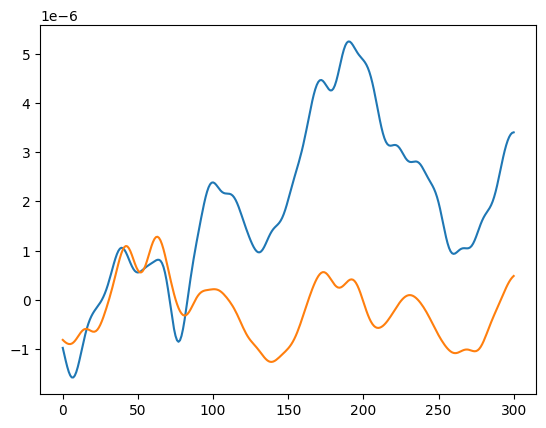

In [117]:
plt.plot(target)
plt.plot(nontarget)

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('Train size:', Counter(y_train))
print('Test size:', Counter(y_test))

Train size: Counter({1: 2155, 0: 256})
Test size: Counter({1: 1044, 0: 144})


In [98]:
data = sampling(X=X_train, y=y_train, report=True)

x shape: (2411, 301)
y shape: (2411,)
class ratio: target=256, non-target=2155
x downsampled shape: (512, 301)
y downsampled shape: (512,)
class ratio (downsampled): target=256, non-target=256
x oversampled shape: (4310, 301)
y oversampled shape: (4310,)
class ratio (oversampled): target=2155, non-target=2155
x balanced shape: (4310, 301)
y balanced shape: (4310,)
class ratio (balanced): target=1077, non-target=2154


In [69]:
over = SMOTE()
under = RandomUnderSampler(sampling_strategy=0.5)
# pipe = ImbPipeline(steps=[('over', over), ('under', under)])
# X_train, y_train = pipe.fit_resample(X_train, y_train)
X_train, y_train = over.fit_resample(X_train, y_train)
print(Counter(y_train))

Counter({1: 2155, 0: 2155})


In [36]:
X_test, y_test = under.fit_resample(X_test, y_test)
print(Counter(y_test))

Counter({1: 288, 0: 144})


In [32]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])
X, y, X_down, y_down, X_over, y_over = sampling(dataset, report=False)
data = {'real':{'x': X,
                'y': y},
        'downsample':{'x': X_down,
                      'y': y_down},
        'oversample':{'x': X_over,
                      'y': y_over}}

x shape: (3599, 301)
y shape: (3599,)
class ratio: target=400, non-target=3199
x downsampled shape: (800, 301)
y downsampled shape: (800,)
class ratio (downsampled): target=400, non-target=400
x oversampled shape: (4798, 301)
y oversampled shape: (4798,)
class ratio (oversampled): target=1599, non-target=3199


In [77]:
from sklearn.model_selection import GridSearchCV
svc = SVC(random_state=42)
params = {'C':(1e-3, 1e-2, 1e-1, 1, 10, 100),
          'kernel':('linear', 'poly', 'rbf', 'sigmoid')}
search = GridSearchCV(svc, params, scoring='balanced_accuracy')

search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': (0.001, 0.01, 0.1, 1, 10, 100),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='balanced_accuracy')

In [78]:
print(search.best_params_)
print(search.best_score_)

{'C': 100, 'kernel': 'rbf'}
0.9501160092807425


In [82]:
svm = SVC(C=100, kernel='rbf', random_state=42, class_weight='balanced')
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
svm.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', random_state=42)

In [99]:
y_pred = svm.predict(X_test)
# balanced_accuracy_score(y_test, y_pred)
accuracy_score(y_test, y_pred)

ValueError: Found array with dim 3. SVC expected <= 2.

In [81]:
lda = LDA().fit(X_train, y_train)
y_pred = lda.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5859674329501916

In [ ]:
res = search.cv_results_
df = pd.DataFrame({'kernel':res['param_kernel'].data,
                   'C':res['param_C'].data,
                   'accuracy':res['mean_test_accuracy'],
                   'f1':res['mean_test_f1']})

In [ ]:
df.C = df.C.astype(dtype=str)
df.C.dtype

dtype('O')

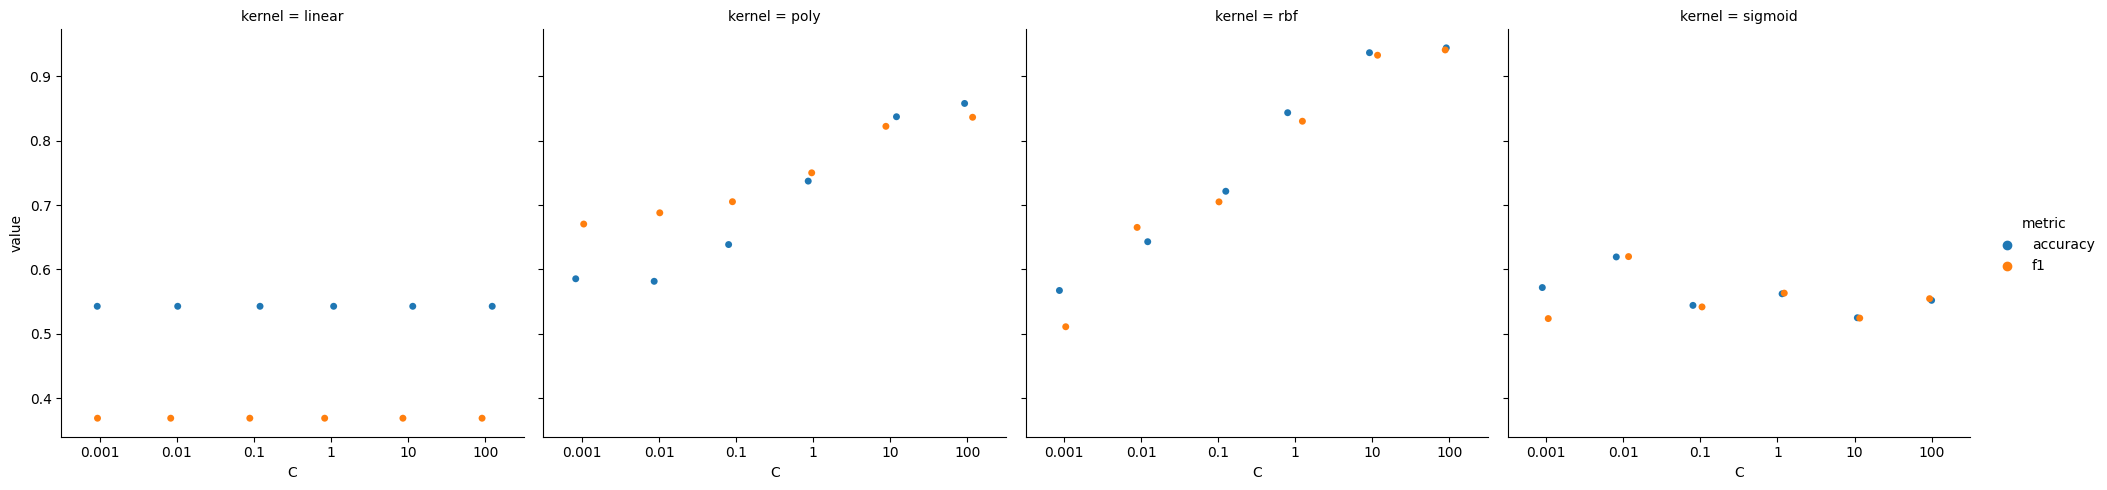

In [ ]:
g = sns.catplot(df, x='C', y='value', col='kernel', hue='metric')

Наилучший результат получается при использовании ядра rbf и параметра регуляризации 10

## LDA и SVM на данных одного испытуемого

In [ ]:
def pipeline(X, y, *models, models_names:list=None, scoring:list=['accuracy'],
             test_size=0.3, scaler=None, sampling_mode:list=None):
    
    names = models_names if models_names else [*range(len(models))]
    assert len(names)==len(models), 'Number of names must be the same as the number of models'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    if scaler:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    data = sampling(X=X_train, y=y_train, mode=sampling_mode)
    
    for k, v in data:
        models_list = list(models).copy()
        

In [15]:
def pipeline(data:dict, *models, models_names:list=None, scoring=['accuracy']):
    '''Process data
    
    data -- dict of dicts with different sampling types each contains X and y
            {'sampling n':{'X':np.ndarray,
                        'y':np.ndarray}}
    models -- models to call .fit method
    models_names -- labels of models (to identify in results)
    scoring -- metrics to pass as scoring argument in sklearn cross_validate function
    
    '''
    names = models_names if models_names else [*range(len(models))]
    assert len(names)==len(models), 'Number of names must be the same as the number of models'
    
    res = dict.fromkeys(data.keys())
    
    # for k, v in tqdm(data.items()):
    for k, v in data.items():
        models_list = list(models).copy()
        scores = []
        # for name, model in tqdm(zip(names, models_list), desc='model', leave=False):
        for name, model in zip(names, models_list):
            cv = StratifiedKFold(5, shuffle=True, random_state=42)
            score = cross_validate(model, v['x'], v['y'], cv=cv, scoring=scoring)
            score = pd.DataFrame(score).mean()
            score = score.drop(['fit_time','score_time'])
            score.name = name
            score.index = scoring
            scores.append(score)
        res[k] = pd.DataFrame(scores).T
    return res

In [90]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])
X, y, X_down, y_down, X_over, y_over = sampling(dataset, report=True)
data = {'real':{'x': X,
                'y': y},
        'downsample':{'x': X_down,
                      'y': y_down},
        'oversample':{'x': X_over,
                      'y': y_over}}

x shape: (3599, 301)
y shape: (3599,)
class ratio: target=400, non-target=3199
x downsampled shape: (800, 301)
y downsampled shape: (800,)
class ratio (downsampled): target=400, non-target=400
x oversampled shape: (6398, 301)
y oversampled shape: (6398,)
class ratio (oversampled): target=3199, non-target=3199


In [92]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

lda = make_pipeline(RobustScaler(), LDA())
svm = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42))
svmb = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced'))
res = pipeline(data, lda, svm, svmb, models_names=['LDA', 'SVM', 'SVMb'], scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted'])

In [93]:
df = pd.concat([pd.melt(df.reset_index(names='metric'), id_vars='metric', var_name='model').assign(sampling=k) for k,df in res.items()])
df.head()

,metric,model,value,sampling
0,accuracy,LDA,0.885245,real
1,balanced_accuracy,LDA,0.505624,real
2,f1,LDA,0.939005,real
3,f1_weighted,LDA,0.838197,real
4,accuracy,SVM,0.876077,real


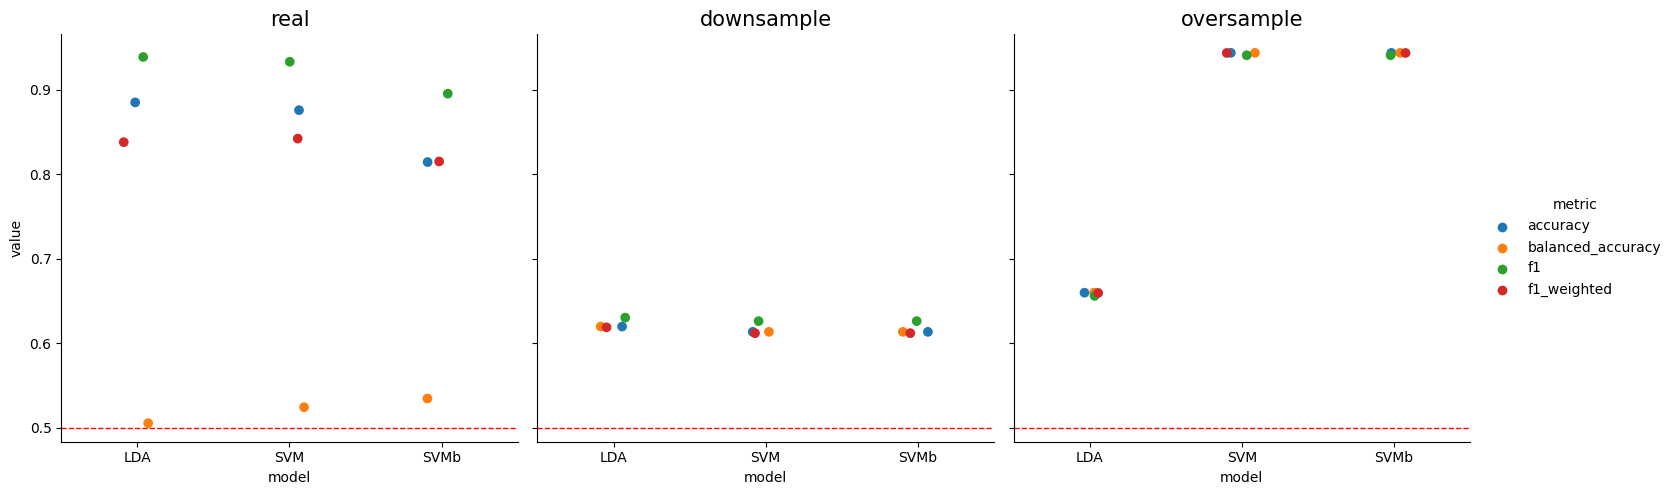

In [94]:
# sns.scatterplot(df, s=60)
# g = sns.FacetGrid(df, col='sampling', hue='metric')
# g = (g.map(sns.catplot).add_legend())
# plt.show()
g = sns.catplot(df, x='model', y='value', hue='metric', col='sampling', size=7)
g.set_titles('{col_name}', size=15)
for ax in g.axes[0]:
    ax.axhline(0.5, ls='--', c='r', lw=1)
plt.show()

Отчетливо видна проблема дисбаланса классов (real), которая наилучшим образом решается добавлением синтетических данных с применением SMOTE (oversample). При этом, SVM справляется гораздо лучше LDA.

## Конфигурации элкетродов

In [20]:
# Порядок электродов
from ast import literal_eval
with open('./P300BCI_DataSet/eeg_ch_names.txt', 'r') as f:
    chnames = literal_eval(f.readline())
print(chnames)

['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO3', 'POz', 'PO4', 'O1', 'O2']


In [21]:
# Наборы каналов
ch_set1 = ['Pz']
ch_set3 = ['Pz', 'Cz', 'POz']
ch_set7 = ['Pz', 'Cz', 'POz', 'P3', 'P4', 'PO3', 'PO4']
ch_set9 = ['Cz', 'Pz', 'POz', 'P3', 'P4', 'P7', 'P8', 'PO3', 'PO4']
ch_set13 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4']
ch_set15 = ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']

In [46]:
# Создадим маски для отбора отдельных каналов данных
# NOTE: это не актуальный формат анализа
# mask1 = [chnames.index(ch) for ch in ['Pz']]
# mask3 = [chnames.index(ch) for ch in ['Pz', 'Cz', 'POz']]
# mask7 = [chnames.index(ch) for ch in ['Pz', 'Cz', 'POz', 'P3', 'P4', 'PO3', 'PO4']]
# mask9 = [chnames.index(ch) for ch in ['Cz', 'Pz', 'POz', 'P3', 'P4', 'P7', 'P8', 'PO3', 'PO4']]
# mask13 = [chnames.index(ch) for ch in ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4']]
# mask15 = [chnames.index(ch) for ch in ['Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']]
# masks = list(map(sorted, [mask1, mask3, mask7, mask9, mask13, mask15]))
# masks

[[34],
 [19, 34, 40],
 [19, 32, 34, 36, 39, 40, 41],
 [19, 30, 32, 34, 36, 38, 39, 40, 41],
 [19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 [19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]]

In [22]:
dataset.data.shape

(3599, 44, 301)

In [23]:
results = []
lda = LDA()
svm = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42))
svmb = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced'))
for group in [ch_set1, ch_set3, ch_set7, ch_set9, ch_set13, ch_set15]:
    
    dataset.pick_channels(group)
    X, y, X_down, y_down, X_over, y_over = sampling(dataset)
    
    data = {'real':{'x': X,
                    'y': y},
            'downsample':{'x': X_down,
                        'y': y_down},
            'oversample':{'x': X_over,
                        'y': y_over}}
    
    results.append(pipeline(data, lda, svmb, svm, models_names=['LDA', 'SVMb', 'SVM'],
                            scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted']))        

100%|██████████| 3/3 [13:27<00:00, 269.00s/it]


In [24]:
dfs = []
for n_ch, res in zip([1,3,7,9,13,15], results):
    dfs.append(pd.concat([pd.melt(df.reset_index(names='metric'), id_vars='metric', var_name='model').assign(sampling=k, n_channels=n_ch) for k,df in res.items()]))
df = pd.concat(dfs)

In [26]:
df.head(10)

,metric,model,value,sampling,n_channels
0,accuracy,LDA,0.885245,real,1
1,balanced_accuracy,LDA,0.505624,real,1
2,f1,LDA,0.939005,real,1
3,f1_weighted,LDA,0.838197,real,1
4,accuracy,SVMb,0.814672,real,1
5,balanced_accuracy,SVMb,0.534828,real,1
6,f1,SVMb,0.895601,real,1
7,f1_weighted,SVMb,0.815355,real,1
8,accuracy,SVM,0.876077,real,1
9,balanced_accuracy,SVM,0.524528,real,1


In [43]:
# df.to_csv('./P300BCI_DataSet/n_channels_comparsion.csv')
df = pd.read_csv('./n_channels_comparsion.csv', index_col=0)
df.head()

,metric,model,value,sampling,n_channels
0,accuracy,LDA,0.885245,real,1
1,balanced_accuracy,LDA,0.505624,real,1
2,f1,LDA,0.939005,real,1
3,f1_weighted,LDA,0.838197,real,1
4,accuracy,SVMb,0.814672,real,1


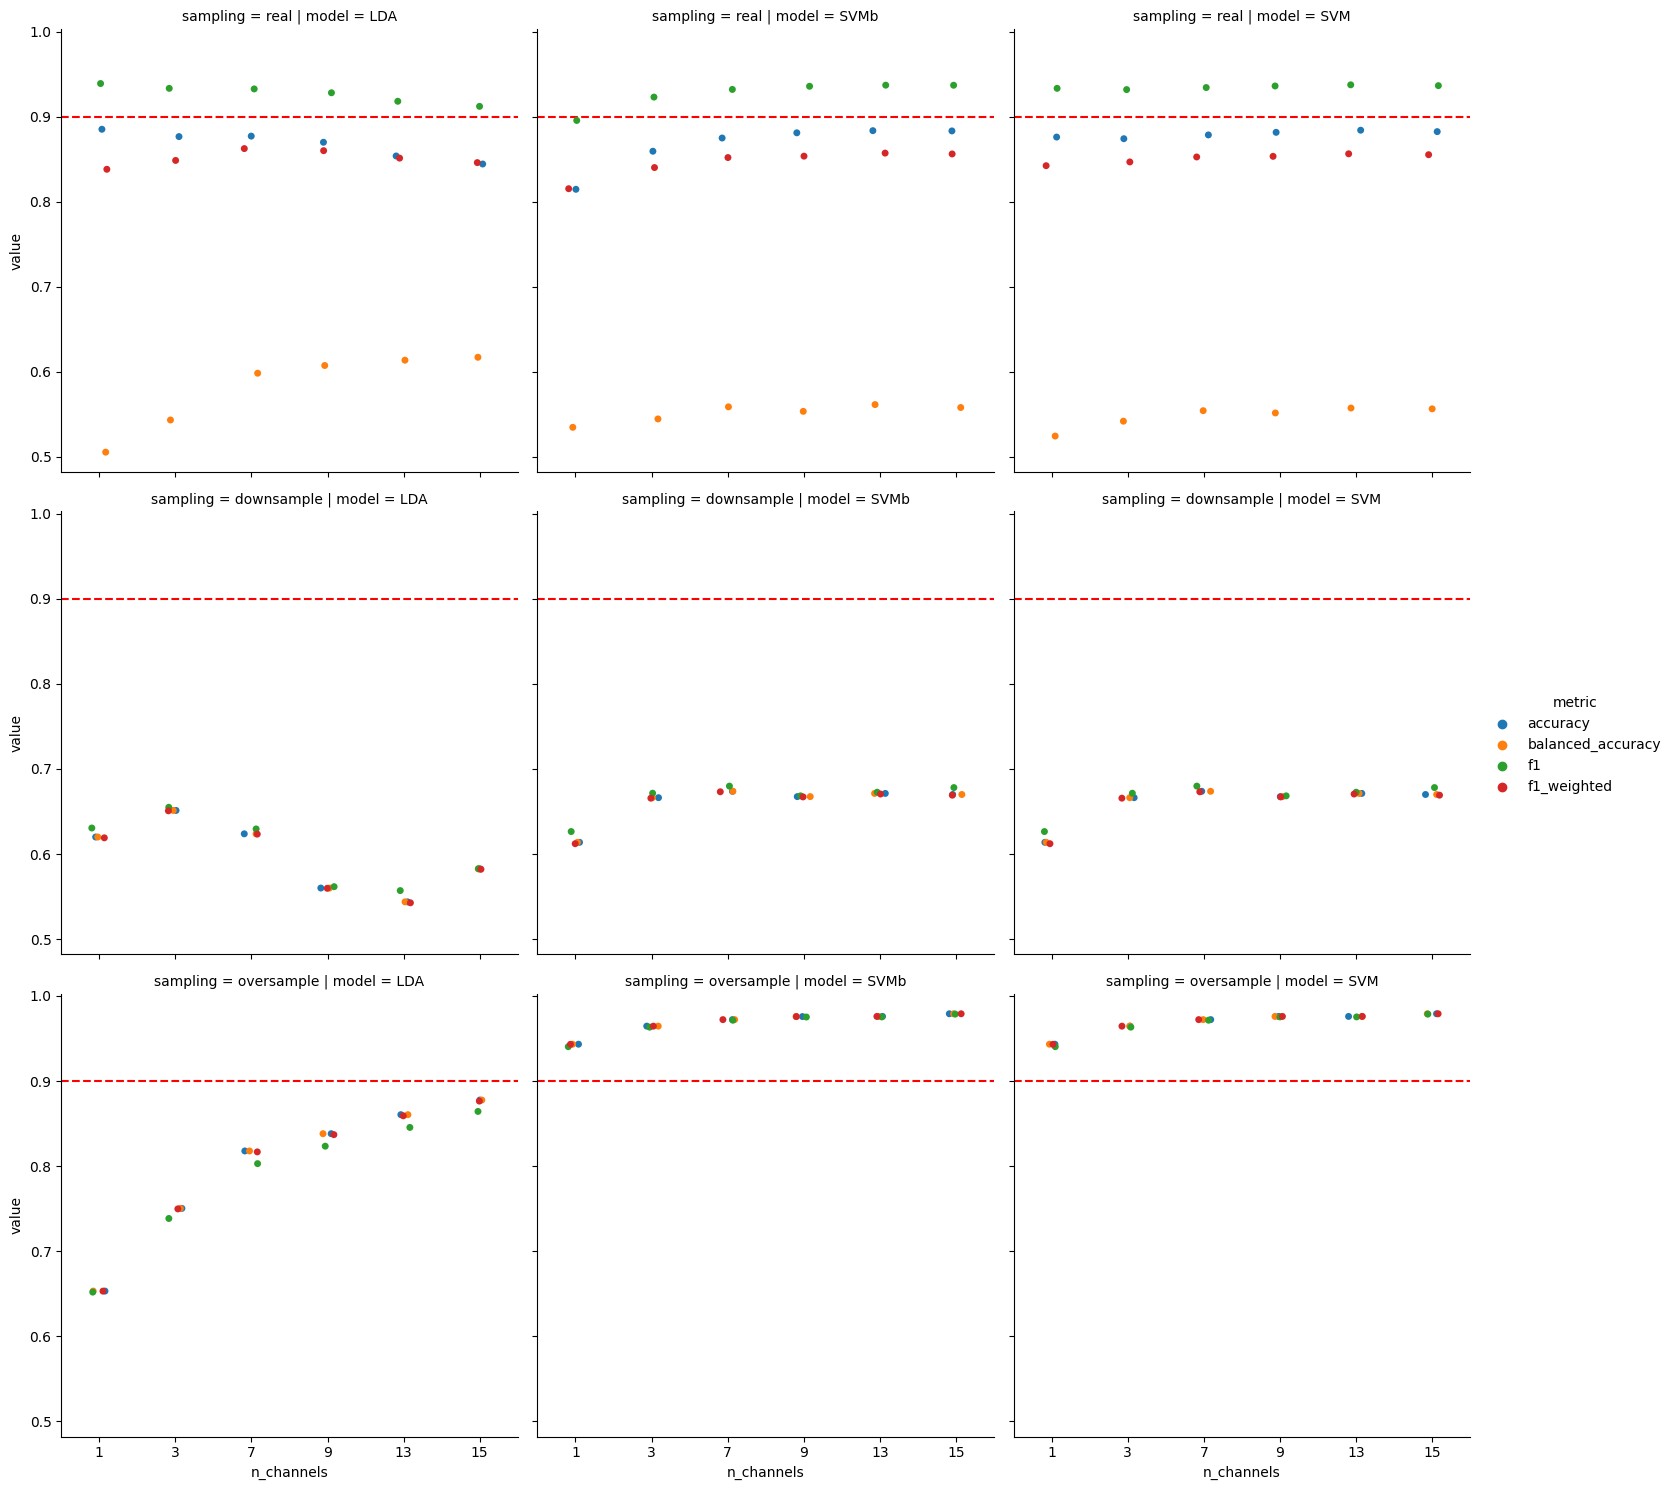

In [51]:
g = sns.catplot(df, x='n_channels', y='value', col='model', row='sampling', hue='metric')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    # ax.set_xticks(np.arange(1,16))

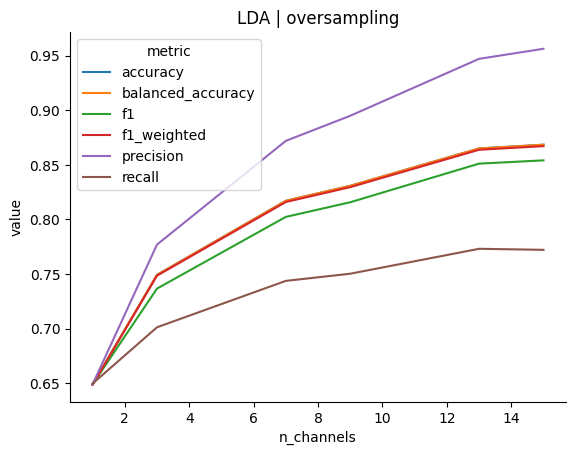

In [31]:
d = df.query('''model=='LDA' & sampling=='oversample' ''')
ax = sns.lineplot(d, x='n_channels', y='value', hue='metric')
ax.set_title('LDA | oversampling')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Увеличение числа каналов положительно влияет на качество классификации, SVM справляется лучше.

## Влияние усреднениея эпох

In [29]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])

In [30]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

ns = []
results = []

for n in range(1,11):
    
    dataset.average(n)
    X, y, X_down, y_down, X_over, y_over = sampling(dataset, report=False)
    data = {'real':{'x': X,
                    'y': y},
            'downsample':{'x': X_down,
                          'y': y_down},
            'oversample':{'x': X_over,
                          'y': y_over}}
    lda = LDA()
    svm = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42))
    svmb = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced'))
    res = pipeline(data, lda, svm, svmb, models_names=['LDA', 'SVM', 'SVMb'], scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted'])
    ns.append(n)
    results.append(res)

100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


In [31]:
dfs = []
for n, res in zip(ns, results):
    dfs.append(pd.concat([pd.melt(df.reset_index(names='metric'), id_vars='metric', var_name='model').assign(sampling=k, n_epochs=n) for k,df in res.items()]))
df = pd.concat(dfs)

In [34]:
df.to_csv('n_epochs_comparsion.csv')

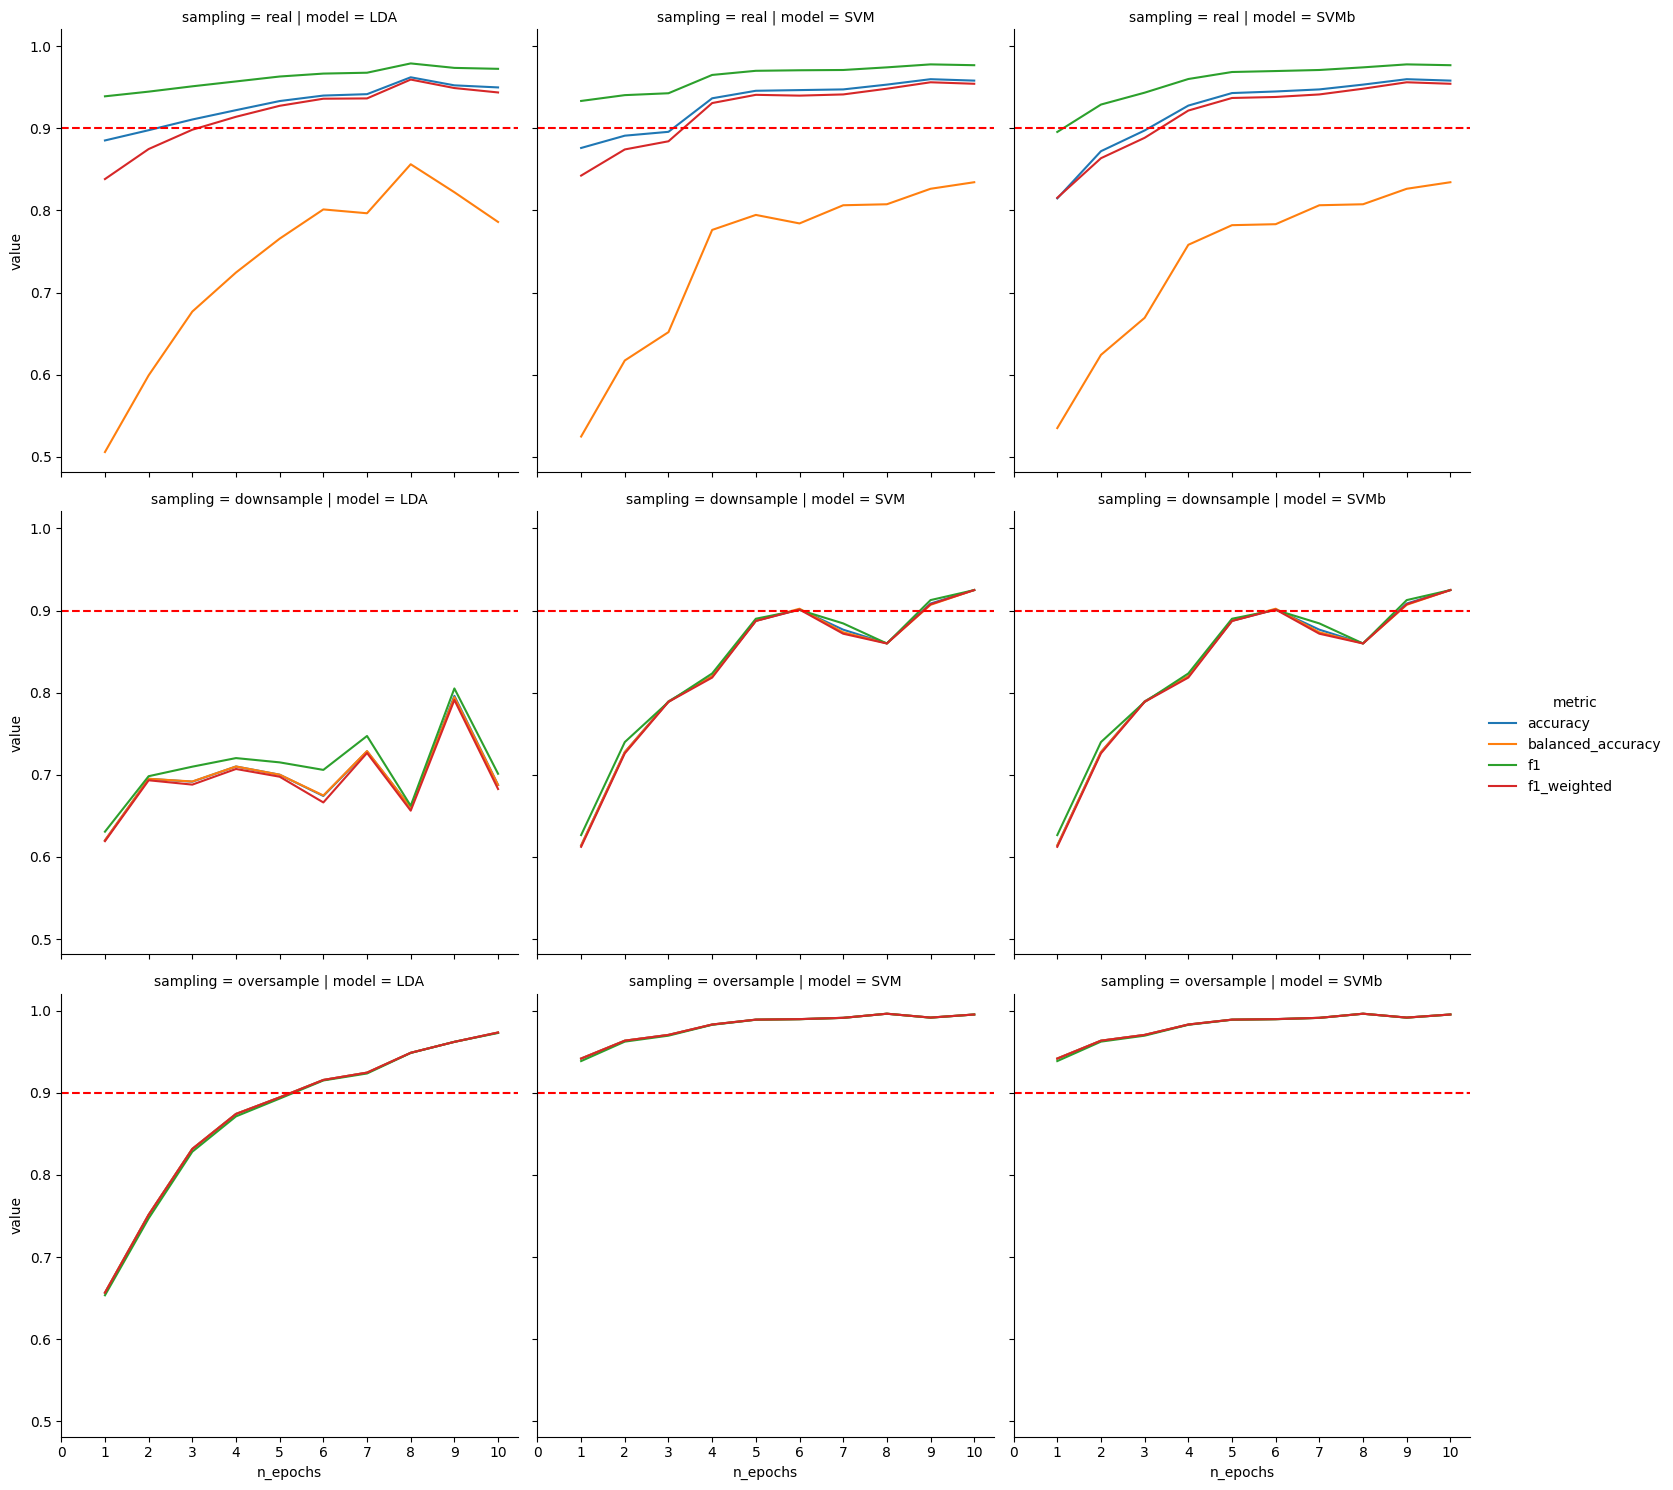

In [33]:
g = sns.relplot(df, x='n_epochs', y='value', hue='metric', col='model', row='sampling', kind='line')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    ax.set_xticks(np.arange(11))

Проведем аналогичные манипуляции, но для большего числа каналов

In [35]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(ch_set7)

In [37]:
ns = []
results = []

for n in range(2,11):
    
    dataset.average(n)
    X, y, X_down, y_down, X_over, y_over = sampling(dataset, report=False)
    data = {'real':{'x': X,
                    'y': y},
            'downsample':{'x': X_down,
                          'y': y_down},
            'oversample':{'x': X_over,
                          'y': y_over}}
    lda = LDA()
    svm = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42))
    svmb = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced'))
    res = pipeline(data, lda, svm, svmb, models_names=['LDA', 'SVM', 'SVMb'], scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted'])
    ns.append(n)
    results.append(res)

100%|██████████| 3/3 [00:12<00:00,  4.20s/it]


In [38]:
dfs = []
for n, res in zip(ns, results):
    dfs.append(pd.concat([pd.melt(df.reset_index(names='metric'), id_vars='metric', var_name='model').assign(sampling=k, n_epochs=n) for k,df in res.items()]))
df = pd.concat(dfs)

In [41]:
# df.to_csv('n_epochs_comparsion_(7_ch).csv')
df = pd.read_csv('n_epochs_comparison_(7_ch).csv')

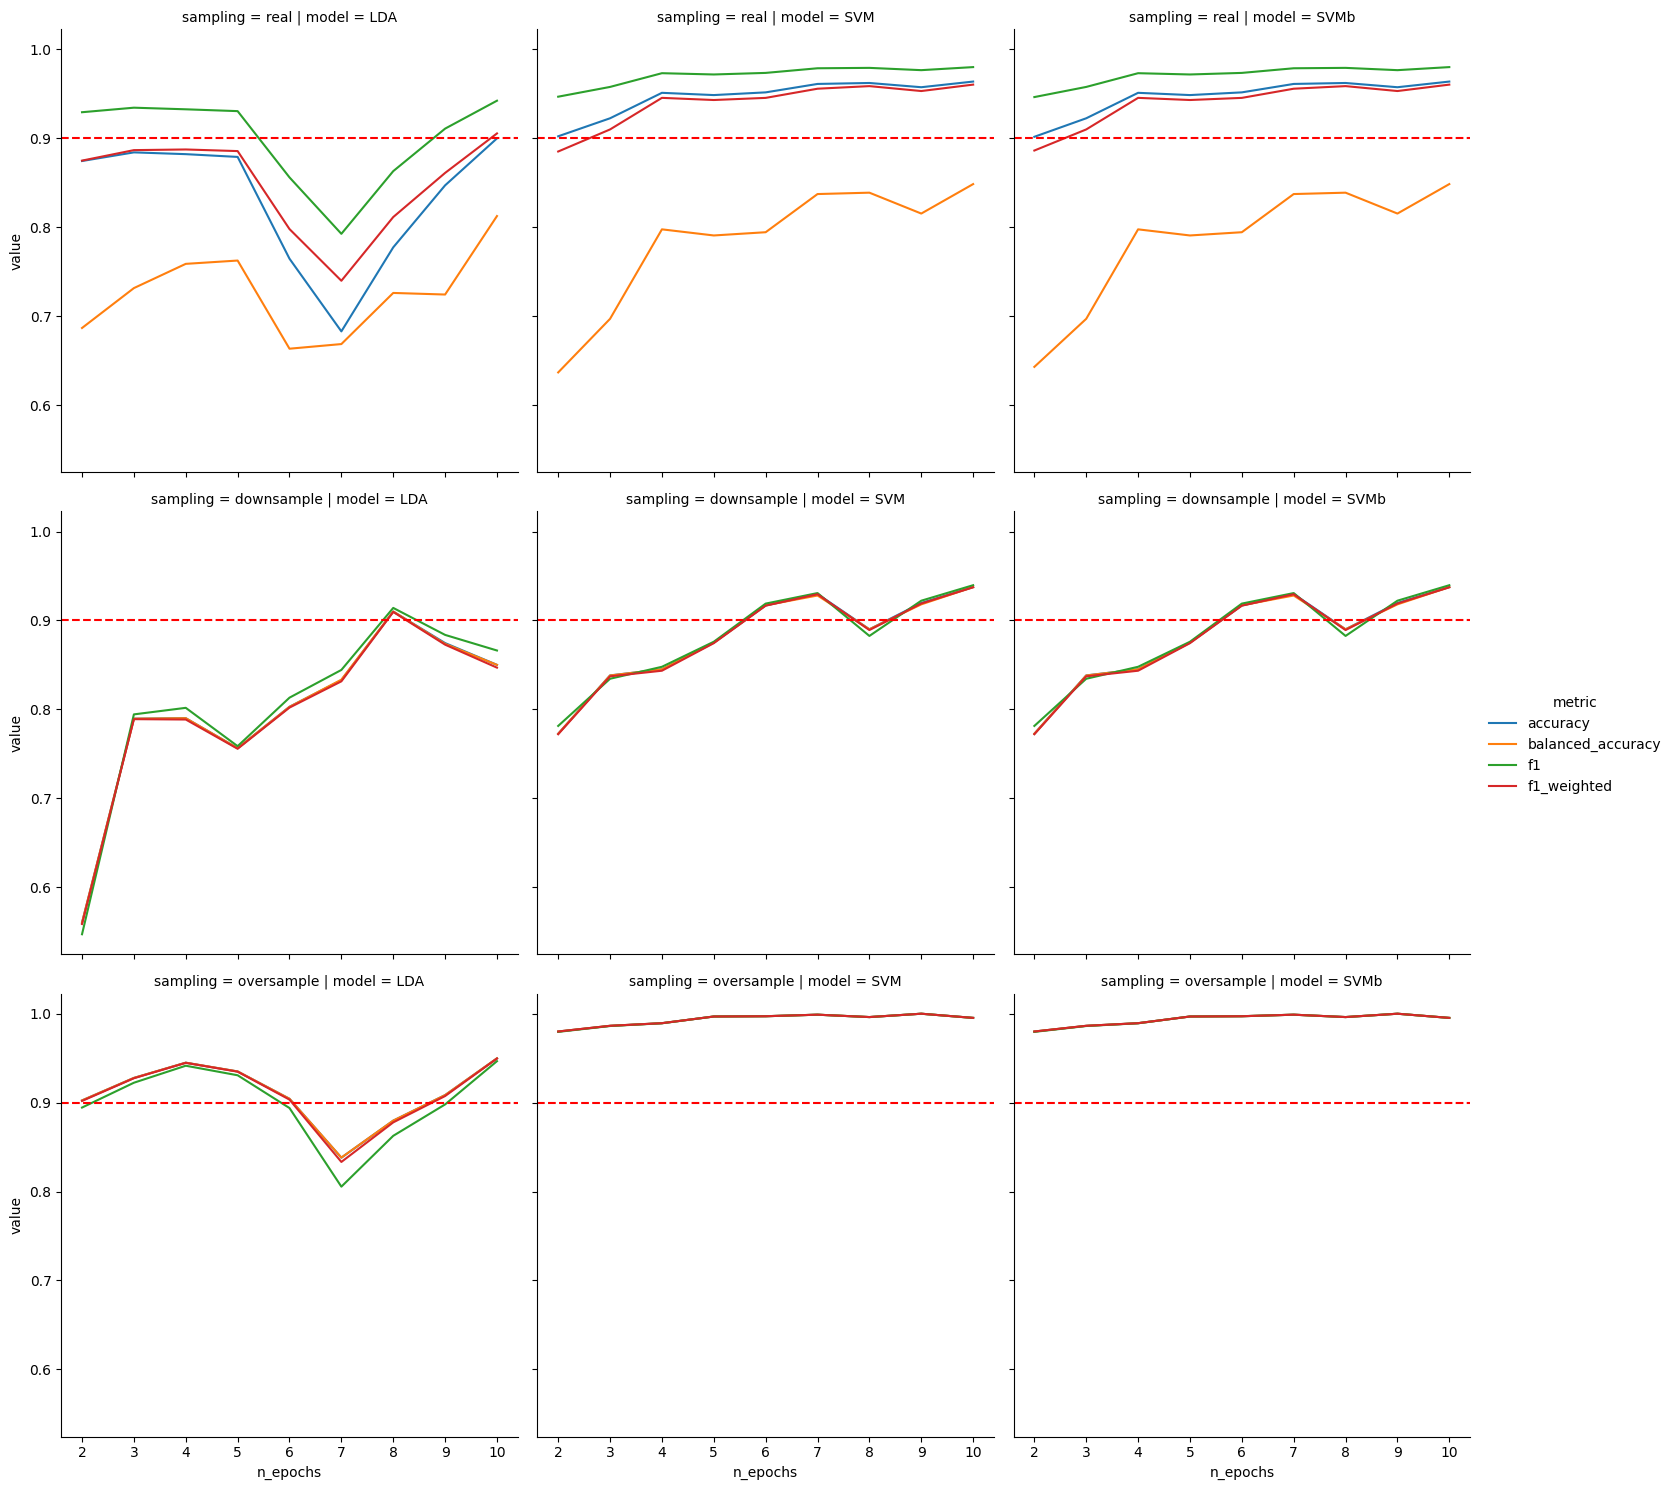

In [40]:
g = sns.relplot(df, x='n_epochs', y='value', hue='metric', col='model', row='sampling', kind='line')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')

Усреднение эпох положительно влияет на точность классификации, как для 1 канала, так и для нескольких

## Влияние объема размера тренировочной выборки

In [52]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])

In [54]:
def separate_data(x, y, part):
    x_t = x[y==0]
    x_nt = x[y==1]
    x_t = x_t[:x_t.shape[0]//part]
    x_nt = x_nt[:x_nt.shape[0]//part]
    x_part = np.vstack([x_t, x_nt])
    y_part = np.hstack([np.zeros(x_t.shape[0]), np.ones(x_nt.shape[0])])
    
    return x_part, y_part

In [65]:
ns = []
results = []
X = dataset.x.copy()
y = dataset.y.copy()
for n in range(1,11):
    x_part, y_part = separate_data(X, y, n)
    X_ori, y_ori, X_down, y_down, X_over, y_over = sampling(X=x_part, y=y_part, report=False)
    data = {'real':{'x': X_ori,
                    'y': y_ori},
            'downsample':{'x': X_down,
                          'y': y_down},
            'oversample':{'x': X_over,
                          'y': y_over}}
    lda = LDA()
    svm = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42))
    svmb = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced'))
    res = pipeline(data, lda, svm, svmb, models_names=['LDA', 'SVM', 'SVMb'], scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted'])
    ns.append(f'1/{n}')
    results.append(res)

100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


In [66]:
dfs = []
for n, res in zip(ns, results):
    dfs.append(pd.concat([pd.melt(df.reset_index(names='metric'), id_vars='metric', var_name='model').assign(sampling=k, n=n) for k,df in res.items()]))
df = pd.concat(dfs)

In [67]:
# df.to_csv('n_part_of_data_comparsion.csv')
df = pd.read_csv('n_part_of_data_comparsion.csv', index_col=0)

In [68]:
df.head()

,metric,model,value,sampling,n
0,accuracy,LDA,0.885245,real,1/1
1,balanced_accuracy,LDA,0.505624,real,1/1
2,f1,LDA,0.939005,real,1/1
3,f1_weighted,LDA,0.838197,real,1/1
4,accuracy,SVM,0.876077,real,1/1


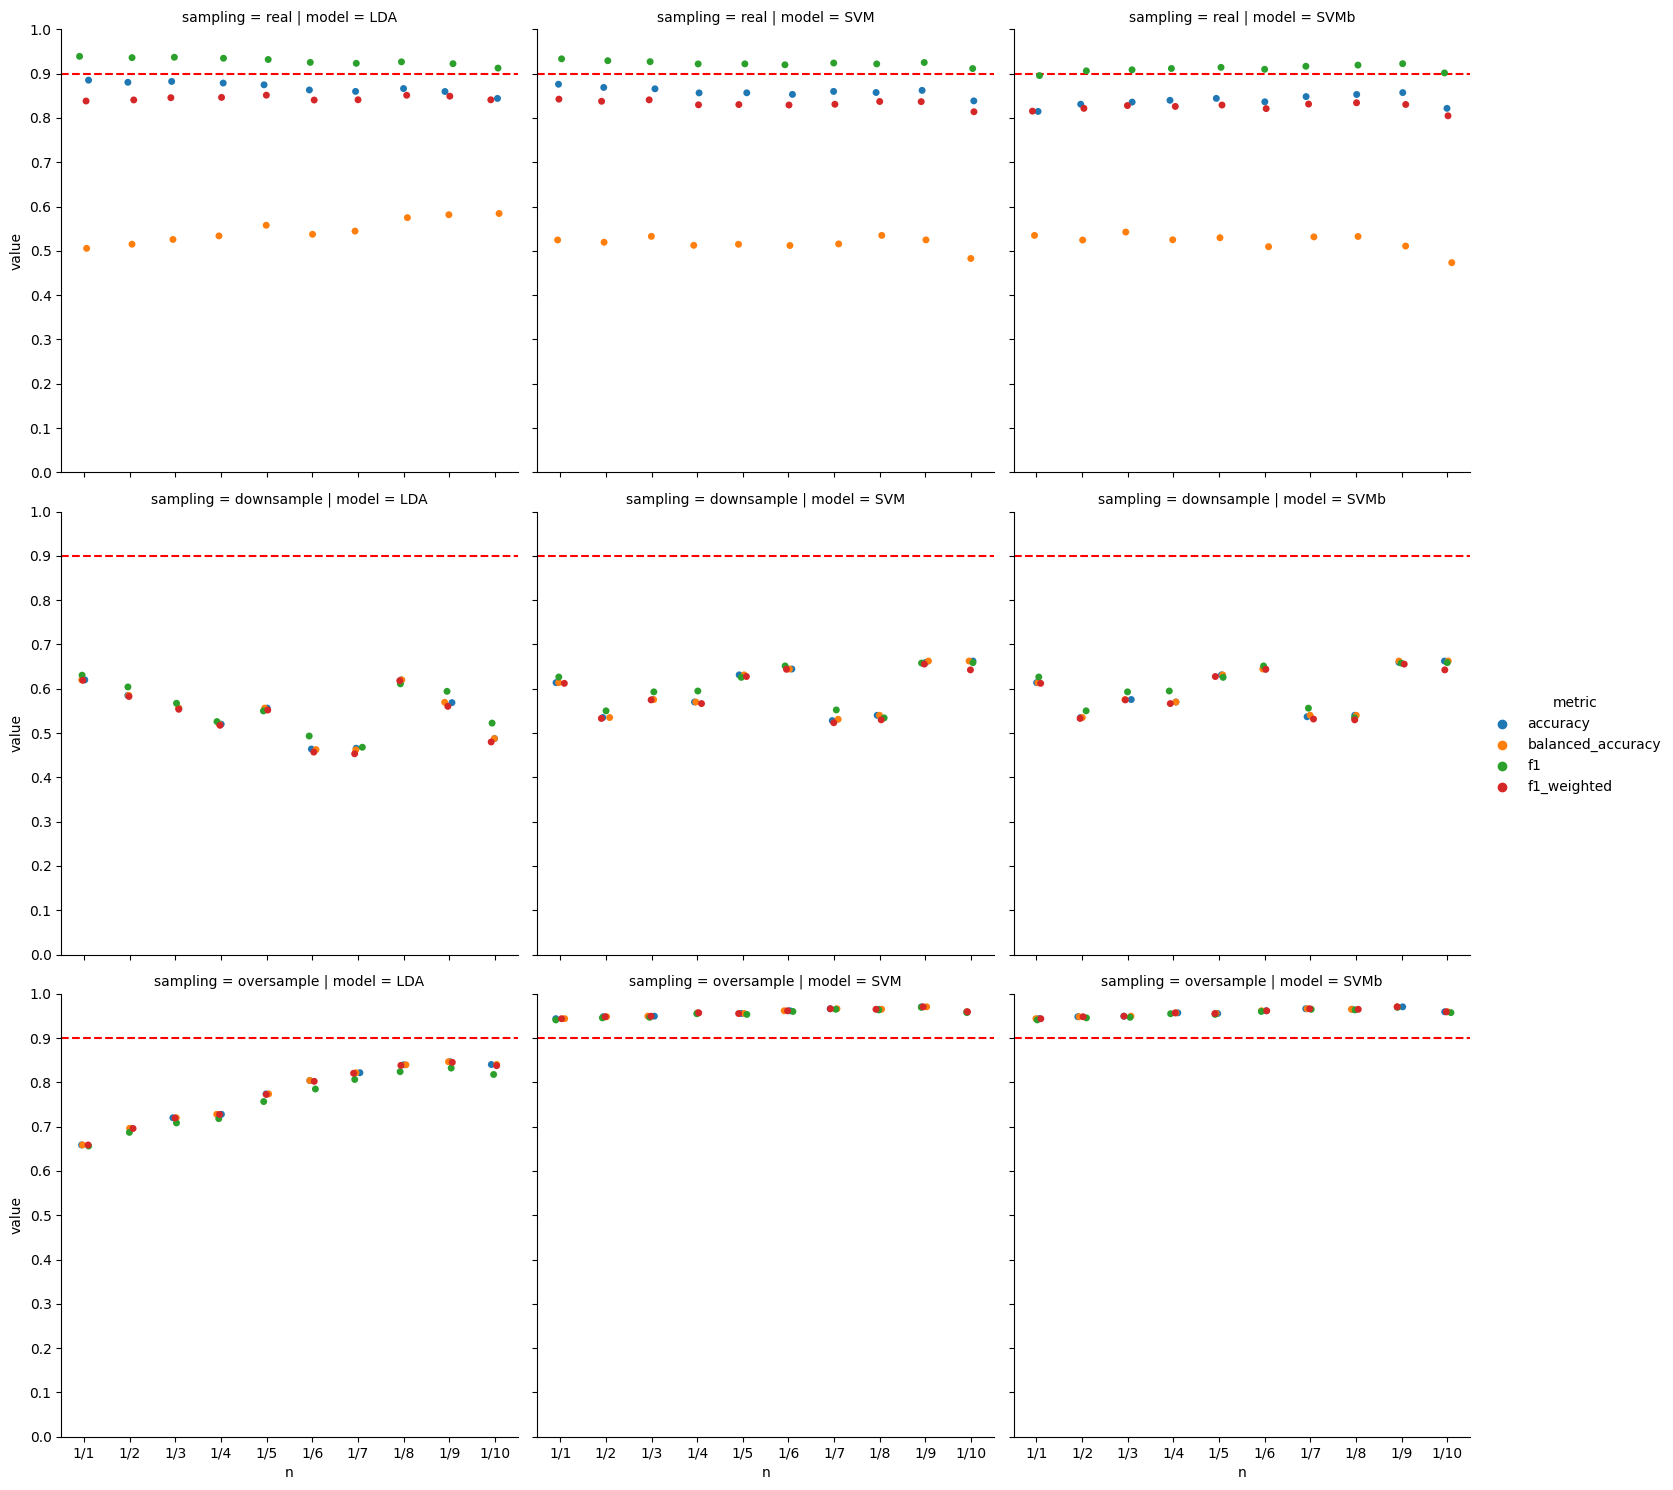

In [69]:
g = sns.catplot(df, x='n', y='value', hue='metric', col='model', row='sampling')
for ax in g.axes.ravel():
    ax.axhline(.9, c='r', ls='--')
    ax.set_ylim((0,1))
    ax.set_yticks(np.arange(0,1.1,0.1))

Можно отметить, что уменьшение объема выборки странно сказвыается на работе классификаторов, SVM по прежнему отлично работает на расширенной выборке, однако по какой-то причине LDA лучше работает на меньшем количесвте исходных данных... 

## Проверим работу классификаторов на разных испытуемых и transfer learning

### Проверим работу классификаторов на всех испытуемых по отдельности

In [64]:
# Список кодов испытуемых
from pprint import pprint

files = os.listdir('./P300BCI_DataSet/')
files = list(filter(lambda x: x.endswith('.npy'), files))
subjects = list(set(map(lambda x:x.split('_')[0], files)))
subjects.sort()

pprint(subjects, compact=True)

['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'eab', 'en', 'fks', 'hra',
 'ieh', 'ik', 'irk', 'kka', 'kms', 'lv', 'mam', 'mb', 'mbm', 'mbu', 'mma', 'mp',
 'nb', 'nva', 'rae', 'rkv', 'sav', 'sdk', 'ski', 'smv', 'ss', 'tg', 'tp']


In [82]:
results = []
for subj in tqdm(subjects):
    dataset = EEGDataset('./P300BCI_DataSet/', subj)
    dataset.pick_channels(['Pz'])
    X, y, X_down, y_down, X_over, y_over = sampling(dataset, report=False)
    data = {'real':{'x': X,
                    'y': y},
            'downsample':{'x': X_down,
                          'y': y_down},
            'oversample':{'x': X_over,
                          'y': y_over}}
    lda = LDA()
    svm = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42))
    svmb = make_pipeline(RobustScaler(), SVC(kernel='rbf', C=10, random_state=42, class_weight='balanced'))
    res = pipeline(data, lda, svm, svmb, models_names=['LDA', 'SVM', 'SVMb'], scoring=['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted'])
    results.append(res)
    

100%|██████████| 35/35 [31:29<00:00, 54.00s/it]


In [83]:
dfs = []
for subject, res in zip(subjects, results):
    dfs.append(pd.concat([pd.melt(df.reset_index(names='metric'), id_vars='metric', var_name='model').assign(sampling=k, subject=subject) for k,df in res.items()]))
df = pd.concat(dfs)

In [86]:
df.to_csv('all_subjects_tests.csv')

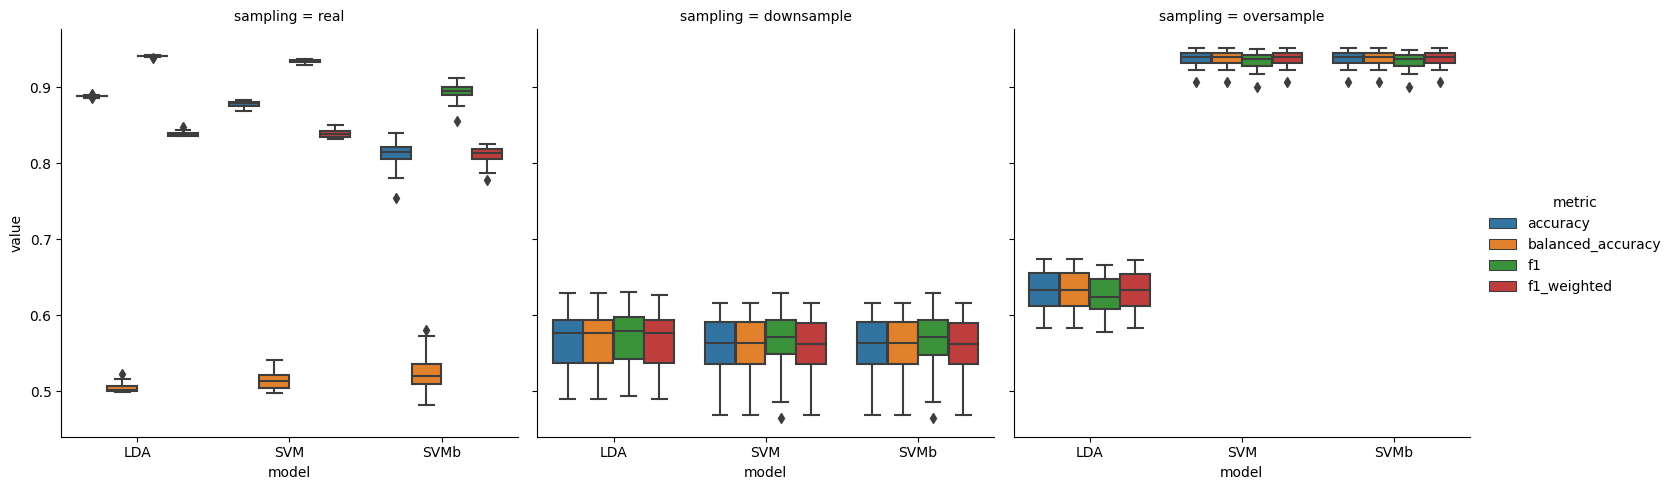

In [89]:
sns.catplot(df, x='model', y='value', col='sampling', hue='metric', kind='box')

Классификаторы показывают примерно равные показатели на разных испытуемых

### Опробуем способность моделей к transfer learning между испытуемыми

In [122]:
datasets = dict((k, v) for k, v in zip(subjects, [{} for _ in range(len(subjects))]))
for subj in tqdm(subjects):
    dataset = EEGDataset('./P300BCI_DataSet/', subj)
    dataset.pick_channels(['Pz'])
    X = flatten(dataset.x.copy())
    y = dataset.y.copy()
    oversamler = SMOTE()
    X, y = oversamler.fit_resample(X, y)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    datasets[subj]['x_train'] = x_train
    datasets[subj]['x_test'] = x_test
    datasets[subj]['y_train'] = y_train
    datasets[subj]['y_test'] = y_test
    

100%|██████████| 35/35 [02:58<00:00,  5.09s/it]


In [123]:
datasets['ik']['x_train'].shape

(4478, 301)

In [124]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

subj_dict = {'train':[], 'test':[]}
models = []
accuracy = []
balanced_accuracy = []
f1 = []
f1_weighted = []
for subj_train, dataset_train in tqdm(datasets.items()):
    
    scaler = RobustScaler().fit(dataset_train['x_train'])
    x_train = scaler.transform(dataset_train['x_train'])
    y_train = dataset_train['y_train']
    lda = LDA()
    svm = SVC(kernel='rbf', C=10, random_state=42).fit(x_train, y_train)
    lda = LDA().fit(x_train, dataset_train['y_train']).fit(x_train, y_train)
    
    for subj_test, dataset_test in datasets.items():
        x_test = scaler.transform(dataset_test['x_test'])
        y_test = dataset_test['y_test']
        for name, model in zip(['LDA', 'SVM'], [lda, svm]):
            subj_dict['train'].append(subj_train)
            subj_dict['test'].append(subj_test)
            models.append(name)
            y_pred = model.predict(x_test)
            accuracy.append(accuracy_score(y_test, y_pred))
            balanced_accuracy.append(balanced_accuracy_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred))
            f1_weighted.append(f1_score(y_test, y_pred, average='weighted'))

100%|██████████| 35/35 [21:56<00:00, 37.61s/it]


In [125]:
res = pd.DataFrame({'train_subject':subj_dict['train'],
                    'test_subject':subj_dict['test'],
                    'model':models,
                    'accuracy':accuracy,
                    'balanced_accuracy': balanced_accuracy,
                    'f1': f1,
                    'f1_weighted':f1_weighted})
res_lda = res[res.model=='LDA']
res_svm = res[res.model=='SVM']

In [126]:
# res.to_csv('all_vs_all_classification_oversample.csv')

<AxesSubplot: xlabel='test_subject', ylabel='train_subject'>

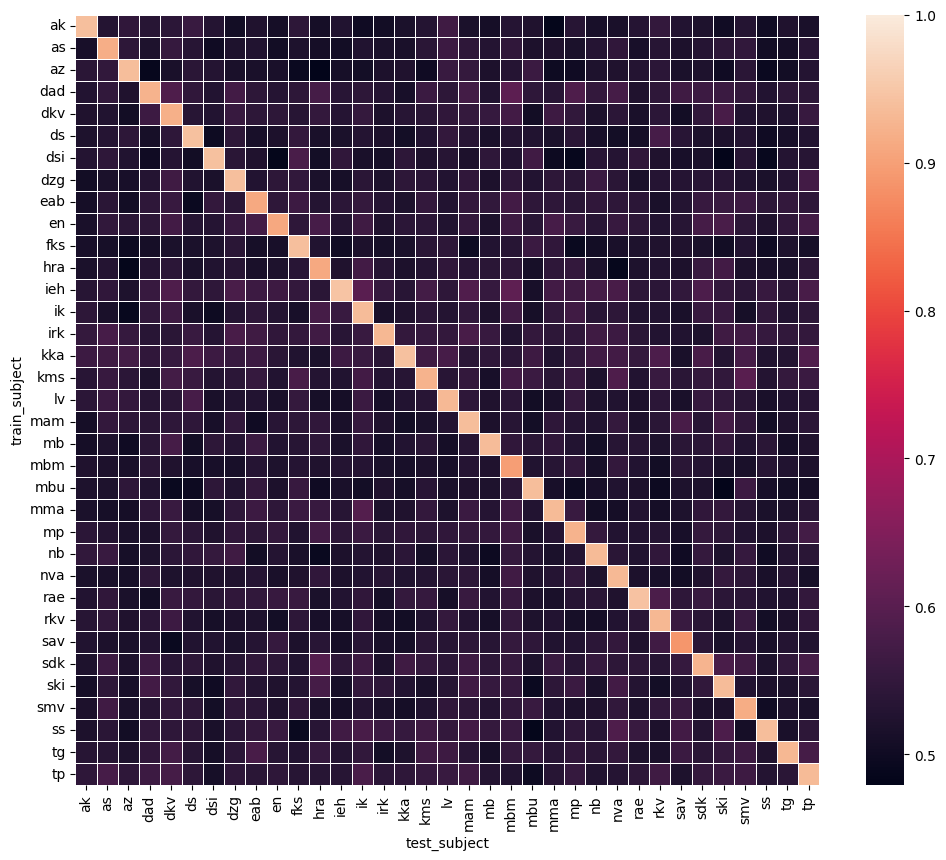

In [133]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(res_svm.pivot(index='train_subject', columns='test_subject', values='accuracy'), linewidths=0.5, ax=ax, vmax=1)

<AxesSubplot: xlabel='test_subject', ylabel='train_subject'>

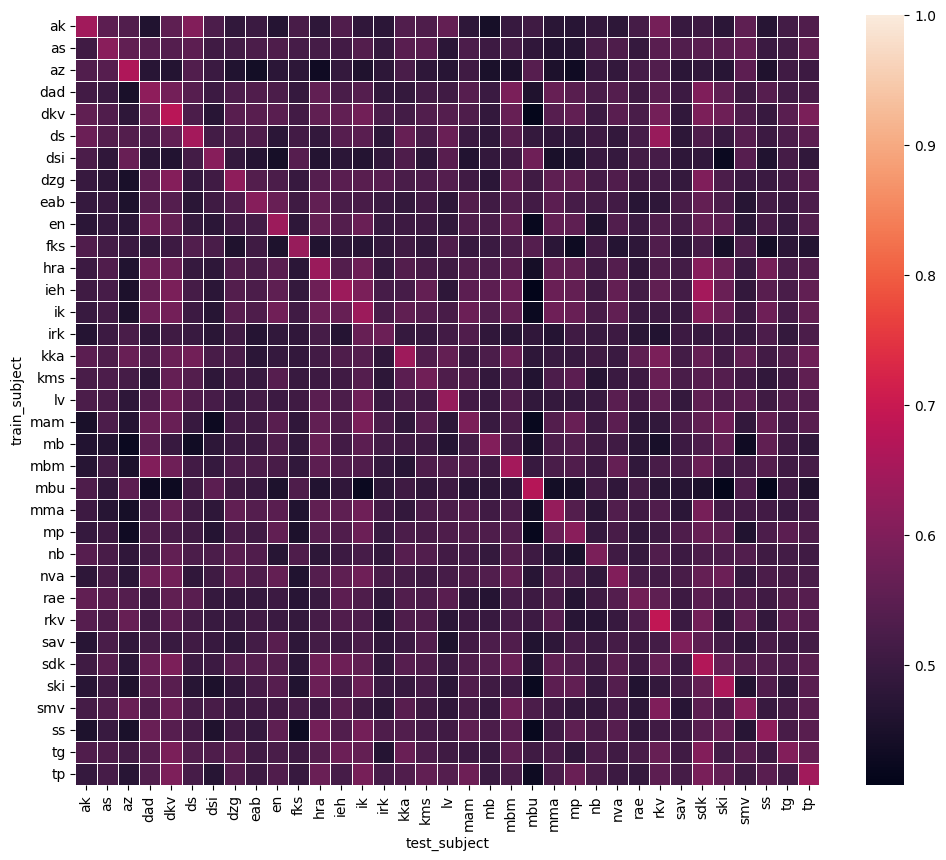

In [132]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(res_lda.pivot(index='train_subject', columns='test_subject', values='accuracy'), linewidths=0.5, ax=ax, vmax=1)

Перенос весов в случае классических классификаторов (без усреднения эпох, 1 канал) невозможен

### Кросс валидация по типу "Один против всех"

In [8]:
from torch import nn

class EEGDatasetAdvanced(Dataset): 
    '''Advanced dataset to operate with wider amount of EEG data'''
    
    def __init__(self, root_dir:str=None, cache=True, load_cache=False, cache_dir_name='eeg_cache',
                 subjects=[], transform=None, **kwargs):
        '''
        Keyword arguments:
        root_dir -- a directory with .npy files that contain epochs
        cache -- flag whether need to cache files or keep in memory NOTE: can be only True now
        load_cache -- flag to load existing cache instead making new one
        cache_dir_name -- name of directory for cache to save it to or load it from
        subjects -- names of subjects to load their data
        transform -- ...
        
        **kwargs:
        downsampling -- int that means the downsampling factor when creating a new cache
        dtype -- numpy.dtype like np.float16 to convert data when creating a new cache
        
        '''
        
        super().__init__()
        
        self.root_dir = root_dir
        self.cache_path = os.path.join(self.root_dir, cache_dir_name)
        self.cache = cache
        self.load_cache = load_cache
        self.subjects = subjects
        self.transform = transform
        
        self.labels_info = {0:'target', 1:'non-target'}
        
        self.get_subjects() # list of available subjects
        self.get_channels() # EEG channels names
        self.load_data(**kwargs) # load data
        if self.subjects != []:
            self.pick_subjects(self.subjects)
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        x = torch.tensor(np.load(os.path.join(self.cache_path, self.data[idx])), dtype=torch.float32)
        y = torch.tensor(int(self.data[idx].split('_')[-2]), dtype=torch.float32)
        # x = x.reshape([x.shape[0], 1, x.shape[1]])
        
        if self.mask:
            # x = x[self.mask, :, :]
            x = x[self.mask, :]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
        
    def load_data(self, **kwargs):
        
        if self.cache:
            
            if not os.path.exists(self.cache_path):
                os.makedirs(self.cache_path)
            if self.load_cache:
                # print('Cache is already available')
                self.data = os.listdir(self.cache_path)
                return
            self._load_and_cache(**kwargs)
        else:
            self._load_in_memory()    
                
    def _load_and_cache(self, downsample=1, dtype=np.float64, **kwargs):
        '''cycle across all subjects to save each epoch separately'''
        
        names = self.subjects if self.subjects else self.available_subjects        
        for name in tqdm(names):
            data = np.load(os.path.join(self.root_dir, f'{name}_c_epochs.npy'))
            labels = np.load(os.path.join(self.root_dir, f'{name}_c_labels.npy'))
            data = data.astype(dtype)[:,:,::downsample]
            for i in range(data.shape[0]):
                np.save(os.path.join(self.cache_path, f'{name}_epoch_{i}_class_{labels[i]}_.npy'), data[i,...])
        print(f'All data is cached in {self.cache_path}')
        self.data = os.listdir(self.cache_path)
        
    def _load_in_memory(self):
        '''make a list of epochs'''
        # TODO
        # I don`t think we need this option in the dataset...
        print('Use EEGDataset instead')
    
    def get_subjects(self):
        '''Get list of subjects of the data'''

        files = os.listdir(self.cache_path) if self.load_cache else os.listdir(self.root_dir)
        files = list(filter(lambda x: x.endswith('.npy'), files))
        self.available_subjects = list(set(map(lambda x:x.split('_')[0], files)))
        self.available_subjects.sort()
        if self.subjects == []:
            self.subjects = self.available_subjects.copy()
        
    def get_channels(self):
        '''Get list of channels (electrodes) in data
        
        Reflects the 2d dimension of (n, 44, 301) in data
        
        '''
        
        # from ast import literal_eval
        # with open('./P300BCI_DataSet/eeg_ch_names.txt', 'r') as f:
        #     self.ch_names = literal_eval(f.readline())
        
        self.ch_names = ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8',
                         'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
                         'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',
                         'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
                         'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
                         'PO3', 'POz', 'PO4', 'O1', 'O2']
        self.mask = None
        
        
            
    def pick_channels(self, channels:list=[]):
        '''Pick some eeg channels according to list of electordes
           given in channels argument
        
        '''
        
        if channels==[]:
            
            self.mask = None
            self.picked_channels = self.ch_names
            return
        
        self.picked_channels = channels
        self.mask = [self.ch_names.index(ch) for ch in channels]
        
    def pick_subjects(self, subjects:list=[]):
        
        self.data = [file for file in self.data if file.split('_')[0] in subjects]
        self.subjects = subjects
        
class Flatten(nn.Module):
    '''Make flat tensor'''
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, tensor):
        
        return tensor.flatten(self.dim)

In [9]:
from copy import deepcopy

class One_vs_all():
    
    def __init__(self, dataset:EEGDatasetAdvanced):
        
        self.dataset = dataset
        self.subjects = dataset.subjects
        self.index = 0
    
    def __iter__(self):
        
        return self
    
    def __next__(self):
        
        if self.index >= len(self.subjects):
            raise StopIteration
        
        subjects = self.subjects.copy()
        test_subject = subjects.pop(self.index)
        train_set = deepcopy(self.dataset)
        test_set = deepcopy(self.dataset)
        train_set.pick_subjects(subjects)
        test_set.pick_subjects([test_subject])
        self.index+=1
        
        return train_set, test_set

In [10]:
from pprint import pprint

dataset = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, transform=Flatten(0))
dataset.pick_channels(['Pz'])
pprint(dataset.subjects, compact=True)

['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'eab', 'en', 'fks', 'hra',
 'ieh', 'ik', 'irk', 'kka', 'kms', 'lv', 'mam', 'mb', 'mbm', 'mbu', 'mma', 'mp',
 'nb', 'nva', 'rae', 'rkv', 'sav', 'sdk', 'ski', 'smv', 'ss', 'tg', 'tp']


In [52]:
splitter = One_vs_all(dataset)
n = 0
for train_set, test_set in splitter:
    if n==5: break
    print(test_set.subjects, len(train_set))
    n+=1
    

['ak'] 121984
['as'] 122042
['az'] 121995
['dad'] 122007
['dkv'] 121985


In [64]:
subjects = dataset.available_subjects.copy()
dataset.pick_channels(['Pz'])

In [80]:
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

subjects_list = []
models = []
accuracy = []
balanced_accuracy = []
f1 = []
f1_weighted = []
subject = 'ak'
train_set = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, subjects=[s for s in subjects if s != subject])
test_set = EEGDatasetAdvanced('./P300BCI_DataSet/', load_cache=True, subjects=[subject])
train_loader = DataLoader(train_set, 128, True)
test_loader = DataLoader(test_set, 128, shuffle=False)
lda = LDA()
svm = SVC(C=10, kernel='rbf', random_state=42)
n = 0
for batch, y_train in train_loader:
    x_train = flatten(batch)
    lda.fit(x_train, y_train)
    svm.fit(x_train, y_train)
    clear_output()
    n+=1
    print(f'{n}/{len(train_loader)} done')
    
for name, model in zip(['LDA', 'SVM'], [lda, svm]):
    subjects_list.append(subject)
    models.append(name)
    accs = []
    acbs = []
    f1s = []
    f1ws = []
    for x_test, y_test in test_loader:
        x_test = flatten(x_test)
        y_pred = model.predict(x_test)
        accs.append(accuracy_score(y_test, y_pred))
        acbs.append(balanced_accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        f1ws.append(f1_score(y_test, y_pred, average='weighted'))
    accuracy.append(np.array(accs).mean())
    balanced_accuracy.append(np.array(acbs).mean())
    f1.append(np.array(f1s).mean())
    f1_weighted.append(np.array(f1ws).mean())

953/953 done


In [81]:
accuracy

[0.8246228448275862, 0.8865840517241379]

# Тестирование без оверсемпла

In [122]:
dataset = EEGDataset('./P300BCI_DataSet/', 'ik')
dataset.pick_channels(['Pz'])
X = flatten(dataset.x.copy())
y = dataset.y.copy()

In [109]:
X = np.vstack([X[y==1], X[y==0].repeat(6, axis=0)])
y = np.hstack([y[y==1], y[y==0].repeat(6)])

In [123]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_train = np.vstack([x_train[y_train==1], x_train[y_train==0].repeat(6, axis=0)])
y_train = np.hstack([y_train[y_train==1], y_train[y_train==0].repeat(6)])
# over = SMOTE(sampling_strategy=0.5)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# pipe = Pipeline(steps=steps)
# x_train, y_train = pipe.fit_resample(x_train, y_train)
# X, y, X_down, y_down, X_over, y_over = sampling(X=x_train, y=y_train, report=True)
# data = {'real':{'x': X,
#                 'y': y},
#         'downsample':{'x': X_down,
#                       'y': y_down},
#         'oversample':{'x': X_over,
#                       'y': y_over}}

In [103]:
c = Counter(y_train)
print(c)

Counter({1: 2255, 0: 1584})


In [106]:
n_target = c[0]
x_test = np.vstack([x_test[y_test==0], x_test[y_test==1][:n_target]])
y_test = np.hstack([y_test[y_test==0], y_test[y_test==1][:n_target]])

In [120]:
svm = SVC(random_state=42)
svm.fit(x_train, y_train)

SVC(random_state=42)

In [121]:
y_pred = svm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('accuracy_balanced:', balanced_accuracy_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

accuracy: 0.7888888888888889
accuracy_balanced: 0.5514183041516936
f1: 0.8782051282051282


In [125]:
from sklearn.model_selection import GridSearchCV
svc = SVC(random_state=42)
params = {'C':(1e-3, 1e-2, 1e-1, 1, 10, 100),
          'kernel':('linear', 'poly', 'rbf', 'sigmoid')}
search = GridSearchCV(svc, params, scoring='balanced_accuracy')

search.fit(x_train, y_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': (0.001, 0.01, 0.1, 1, 10, 100),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='balanced_accuracy')

In [126]:
search.best_params_

{'C': 0.1, 'kernel': 'rbf'}

In [128]:
search.best_score_

0.5741334306323502

In [ ]:
res = search.cv_results_
df = pd.DataFrame({'kernel':res['param_kernel'].data,
                   'C':res['param_C'].data,
                   'accuracy':res['mean_test_accuracy'],
                   'f1':res['mean_test_f1']})

In [ ]:
df.C = df.C.astype(dtype=str)
df.C.dtype

dtype('O')

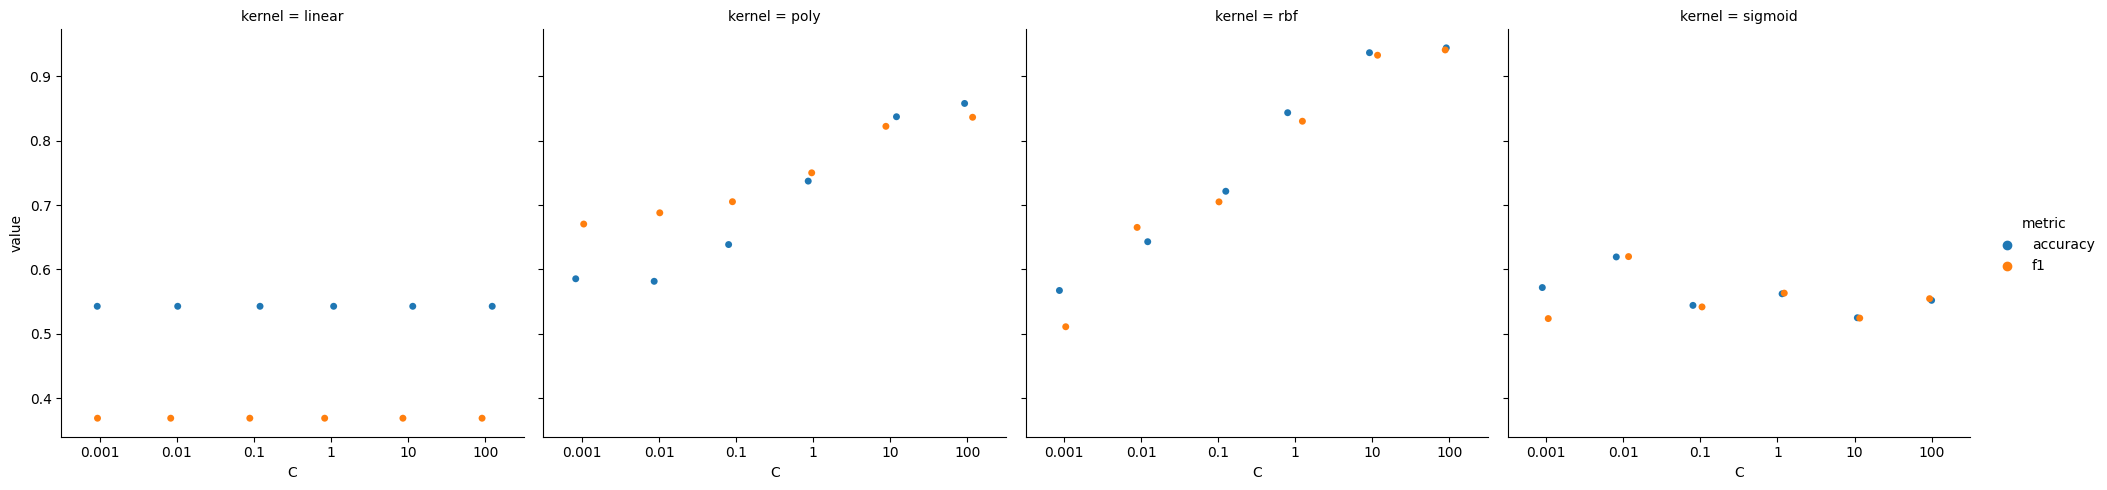

In [ ]:
g = sns.catplot(df, x='C', y='value', col='kernel', hue='metric')